In [1]:
import yfinance as yf

msft = yf.Ticker("MSFT")
df=msft.history(period="max")
df.drop(['Dividends', 'Stock Splits','Volume','Low','High','Open'], axis=1, inplace=True)
df['Date'] = df.index
df.reindex(columns=['Date','Close'])

,Date,Close
Date,,
1986-03-13 00:00:00-05:00,1986-03-13 00:00:00-05:00,0.059827
1986-03-14 00:00:00-05:00,1986-03-14 00:00:00-05:00,0.061963
1986-03-17 00:00:00-05:00,1986-03-17 00:00:00-05:00,0.063032
1986-03-18 00:00:00-05:00,1986-03-18 00:00:00-05:00,0.061429
1986-03-19 00:00:00-05:00,1986-03-19 00:00:00-05:00,0.060361
...,...,...
2024-12-31 00:00:00-05:00,2024-12-31 00:00:00-05:00,421.500000
2025-01-02 00:00:00-05:00,2025-01-02 00:00:00-05:00,418.579987
2025-01-03 00:00:00-05:00,2025-01-03 00:00:00-05:00,423.350006


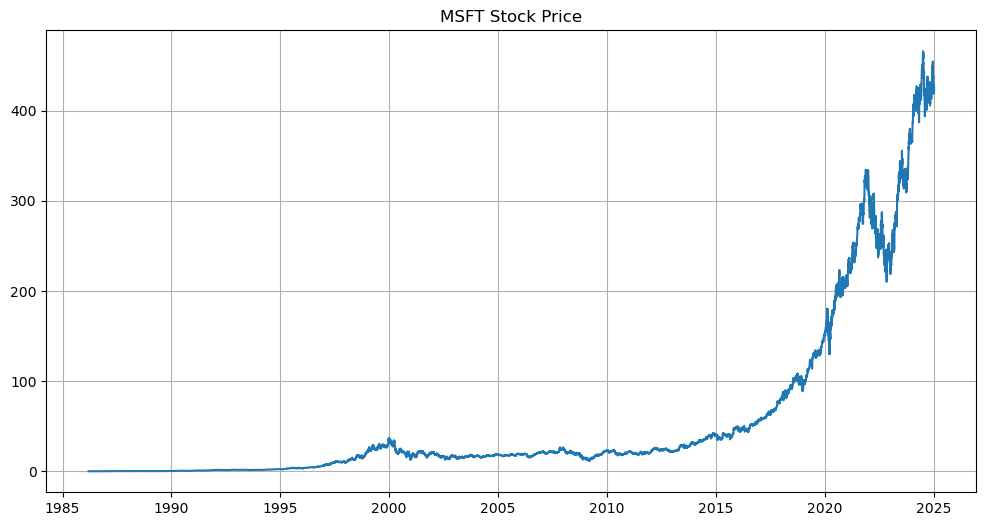

In [2]:
import datetime
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df['Close'])
plt.title('MSFT Stock Price')
plt.grid()
plt.show()

In [3]:
df['Target-1']=df['Close'].shift(1)
df['Target-2']=df['Close'].shift(2)
df['Target-3']=df['Close'].shift(3)
df.dropna(inplace=True)

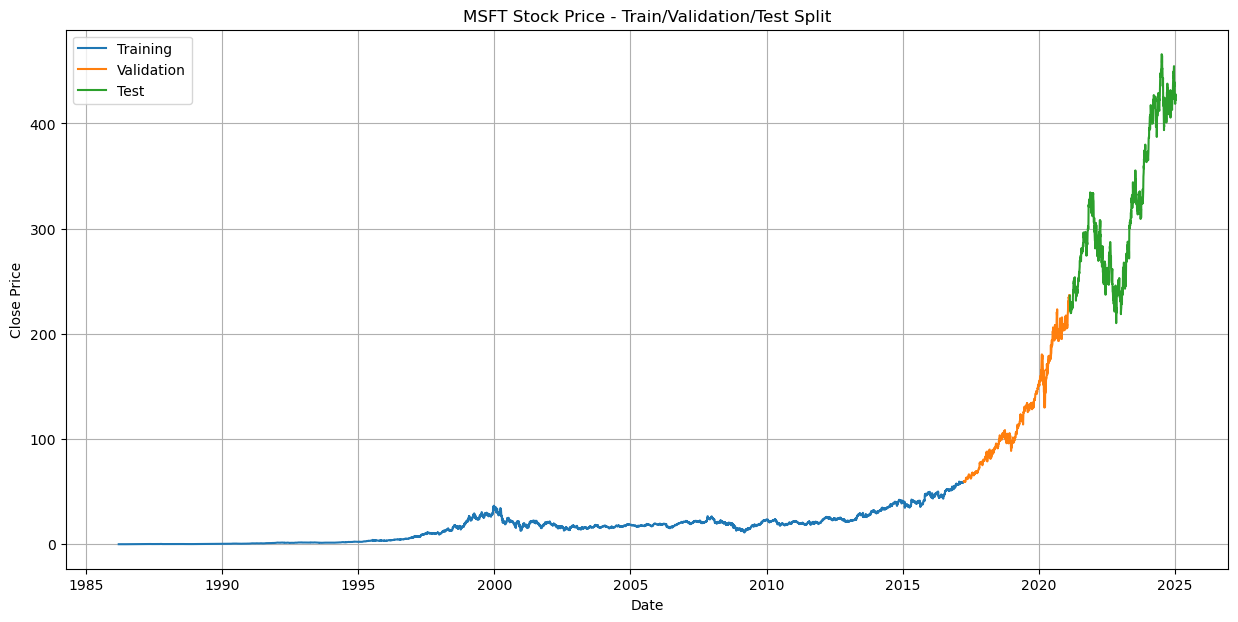

In [4]:
# Calculate split points for 80-10-10 ratio
n = len(df)
train_size = int(0.8 * n)
val_size = int(0.1 * n)

# Split the data
train_df = df[:train_size]
val_df = df[train_size:train_size+val_size]
test_df = df[train_size+val_size:]

# Plot
plt.figure(figsize=(15,7))
plt.plot(train_df['Date'], train_df['Close'], label='Training')
plt.plot(val_df['Date'], val_df['Close'], label='Validation')
plt.plot(test_df['Date'], test_df['Close'], label='Test')
plt.title('MSFT Stock Price - Train/Validation/Test Split')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

import torch.nn as nn

# Define LSTM model
class LSTMPredictor(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=2):
        super(LSTMPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.fc(lstm_out[:,-1,:])
        return predictions

# Create dataset
X = torch.FloatTensor(df[['Target-1', 'Target-2', 'Target-3']].values)
y = torch.FloatTensor(df['Close'].values).reshape(-1, 1)

# Split into train/val/test sets
X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]
X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

# Initialize model, loss and optimizer
model = LSTMPredictor(input_size=1, hidden_size=64, num_layers=2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Training parameters
batch_size = 32
n_epochs = 100

# Training loop
for epoch in range(n_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        # Reshape input to [batch_size, sequence_length, input_size]
        batch_X = X_train[i:i+batch_size].unsqueeze(-1)  # Add feature dimension
        batch_y = y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
    # Validation
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val.unsqueeze(2))
        val_loss = criterion(val_predictions, y_val)
        
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Val Loss: {val_loss.item():.4f}')

Epoch [10/100], Val Loss: 9195.4111
Epoch [20/100], Val Loss: 7589.0933
Epoch [30/100], Val Loss: 6873.5962
Epoch [40/100], Val Loss: 6597.4849
Epoch [50/100], Val Loss: 6467.0093
Epoch [60/100], Val Loss: 6535.5410
Epoch [70/100], Val Loss: 6300.0601
Epoch [80/100], Val Loss: 6241.5327
Epoch [90/100], Val Loss: 6333.2520
Epoch [100/100], Val Loss: 6394.8330


Mean Squared Error: 71195.11
Root Mean Squared Error: 266.82


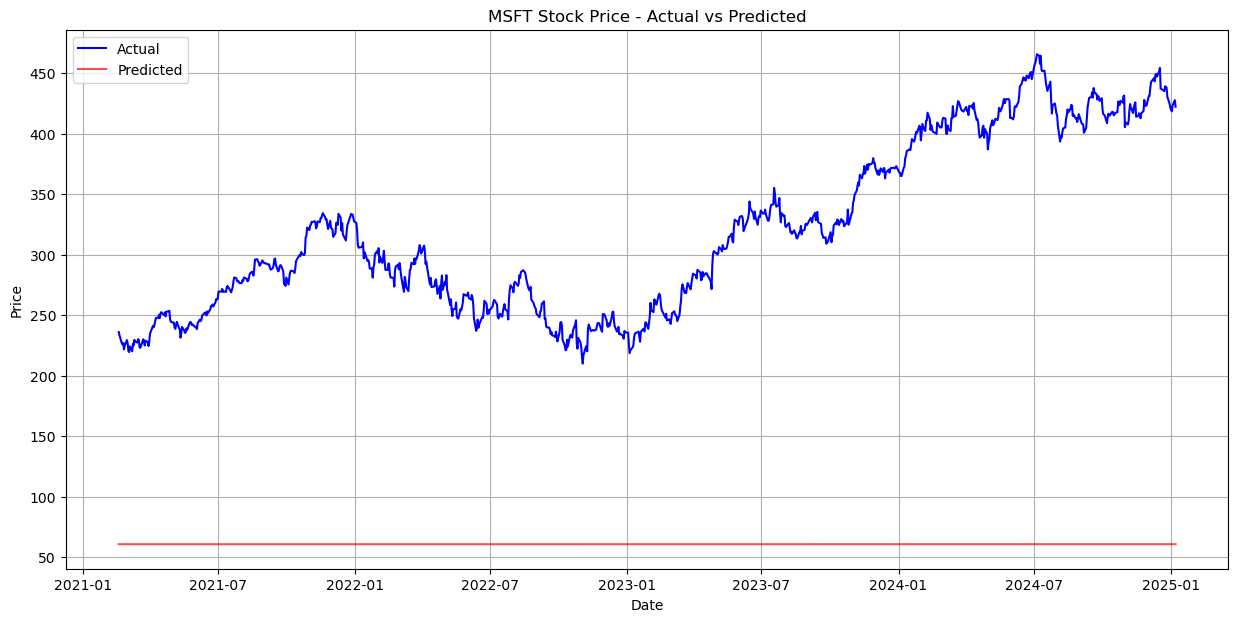

In [8]:
# Generate predictions
model.eval()
with torch.no_grad():
    test_predictions = model(X_test.unsqueeze(2))

# Convert predictions to numpy arrays for plotting
test_predictions = test_predictions.numpy()
y_test_np = y_test.numpy()

# Calculate evaluation metrics
mse = ((test_predictions - y_test_np) ** 2).mean()
rmse = np.sqrt(mse)

# Plot actual vs predicted values
plt.figure(figsize=(15,7))
plt.plot(test_df['Date'], y_test_np, label='Actual', color='blue')
plt.plot(test_df['Date'], test_predictions, label='Predicted', color='red', alpha=0.7)
plt.title('MSFT Stock Price - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Print evaluation metrics
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')